In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import datetime

In [3]:
aust_yld_crv =  [
                (datetime.date(2022,9,20),-0.73),
                (datetime.date(2023,7,15),-0.745),
                (datetime.date(2024,7,15),-0.731),
                (datetime.date(2025,10,20),-0.715),
                (datetime.date(2026,10,20),-0.635),
                (datetime.date(2027,4,20),-0.600),
                (datetime.date(2028,2,20),-0.516),
                (datetime.date(2029,2,20),-0.403),
                (datetime.date(2030,2,20),-0.319),
                (datetime.date(2031,2,20),-0.234),
                (datetime.date(2037,3,15),0.026),
                (datetime.date(2040,10,20),0.222),
                (datetime.date(2047,2,20),0.295),
                (datetime.date(2051,3,20),0.36065),
                (datetime.date(2062,1,26),0.466),
                (datetime.date(2086,11,2),0.655),
                (datetime.date(2120,6,30),0.806103),
                ]

In [4]:
class Bond():
    def __init__(self, acc, mat, cpn, yld, c_dt=datetime.date(2021, 8, 6)):
        '''
        acc = first interest accrual date
        mat = maturity date
        cpn = coupon in percent

        c_dt = current date
        yld = yield in percent
        '''
        self.acc = acc
        self.mat = mat
        self.cpn = cpn
        self.tenor = mat.year - acc.year
        self.cpn_dates = self.get_cpn_dates()
        self.yld = yld
        self.c_dt = c_dt

    def get_cpn_dates(self):
        '''
        Output: list of cpn payment dates using first accrual, assume Act/Act Annual
        '''
        return [datetime.date(self.acc.year + i + 1, self.acc.month, self.acc.day) for i in range(self.tenor)]

    def get_discount_factors(self):
        '''
        Output: list of discount factors from cpn_dates, assuming flat yield
        '''
        val_cpn_dates = [i for i in self.cpn_dates if i > self.c_dt]
        year_frac = [(i - self.c_dt).days / 365. for i in val_cpn_dates]
        discount_rates = [self.yld / 100.] * len(val_cpn_dates)
        return [1 / ((1 + discount_rates[i]) ** year_frac[i]) for i in range(len(year_frac))]

    def dirty_px(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dirty price
        '''
        disc_fact = self.get_discount_factors()
        return sum([d * self.cpn for d in disc_fact]) + (100 * disc_fact[-1])

    def clean_px(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dirty price
        '''
        next_year_frac = ([i for i in self.cpn_dates if i > self.c_dt][0] - self.c_dt).days / 365.
        next_disc_fact = self.get_discount_factors()[0]
        dirty_px = self.dirty_px()
        return dirty_px - (1 - next_year_frac) * next_disc_fact * self.cpn

    def dv01(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: dv01
        '''
        px_base = self.dirty_px()
        start_yld = self.yld
        self.yld = start_yld + 0.01
        px_up = self.dirty_px()
        self.yld = start_yld - 0.01
        px_down = self.dirty_px()
        self.yld = start_yld
        return 100 * (px_down - px_up) / 2.0

    def convexity(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: convexity
        '''
        dv01_base = self.dv01()
        yld_base = self.yld
        self.yld = yld_base + 0.01
        dv01_up = self.dv01()
        self.yld = yld_base - 0.01
        dv01_down = self.dv01()
        self.yld = yld_base
        return 100 * abs(dv01_up - dv01_down) / 2.

    def mod_duration(self):
        '''
        Inputs: c_dt, maturity, cpn, yld
        Output: modified duration
        '''
        dv01 = self.dv01()
        dirty_px = self.dirty_px()
        return 100 * (1 / dirty_px) * dv01

In [5]:
def yld_scenarios(bd,yld_chg):
    '''
    bd: A bond object as defined above
    yld_chg: basis points to move yield up and down
    return: list of dirty pxs,dv01,dollar convexity
    '''
    start_yld = bd.yld
    yld_range = range(-yld_chg,yld_chg+1)
    prices = []
    dv01s = []
    convs = []
    for y in yld_range:
        bd.yld = start_yld+y/100
        prices.append(bd.dirty_px())
        dv01s.append(bd.dv01())
        convs.append(bd.convexity())
    return prices,dv01s,convs

def bond_scenarios(bd,t_chg,yld_chg,roll=False):
    '''
    :param bd: bond object
    :param t_chg: how many years forward
    :param y_ch: how many bps to shock yield curve
    :param roll: roll down the yield curve (bool)
    :return: 3 dataframes of prices,dv01s,convexities index by year, columns are yield shocks
    '''
    cols = range(-yld_chg,yld_chg+1)
    px_df = pd.DataFrame(columns=cols)
    dv_df = pd.DataFrame(columns=cols)
    conv_df = pd.DataFrame(columns=cols)
    start_yr = bd.c_dt.year
    start_yld = bd.yld
    for i in range(t_chg+1):
        bd.yld = start_yld
        eval_date = datetime.date(start_yr+i,bd.c_dt.month,bd.c_dt.day)
        if roll:
            xp = [datetime.date(j[0].year+i,j[0].month,j[0].day).toordinal() for j in aust_yld_crv]
            fp = [k[1] for k in aust_yld_crv]
            bd.yld = np.interp(bd.mat.toordinal(),xp,fp)
        bd.c_dt = datetime.date(start_yr+i,bd.c_dt.month,bd.c_dt.day)
        prices, dv01s, convs = yld_scenarios(bd,yld_chg)
        px_df.loc[eval_date] = prices
        dv_df.loc[eval_date] = dv01s
        conv_df.loc[eval_date] = convs
    return px_df,dv_df,conv_df

def flattener_scenarios(bd1,bd2):
    '''

    :param bd1: px,dv01,conv for bond1 - short this bond
    :param bd2: px,dv01,conv for bond2 - long this bond
    :return: total_pnl,total_dv01,total_convexity - all dataframes
    '''

    scalar_1 = -100/bd1[1][0][0]
    scalar_2 = 100/bd2[1][0][0]

    px_df_30y, dv_df_30y, conv_df_30y = bd1[0]*scalar_1,bd1[1]*scalar_1,bd1[2]*scalar_1/100
    px_df_100y, dv_df_100y, conv_df_100y = bd2[0]*scalar_2,bd2[1]*scalar_2,bd2[2]*scalar_2/100
    pnl_30y = 100*(px_df_30y - px_df_30y[0][0])
    pnl_100y = 100*(px_df_100y - px_df_100y[0][0])
    total_pnl = pnl_30y+pnl_100y
    total_dv = dv_df_30y+dv_df_100y
    total_conv = conv_df_30y+conv_df_100y
    return  total_pnl,total_dv,total_conv

def x_intercept(total_df):
    '''
    find the x-intercept of incremental scenarios
    '''
    cols = list(total_df.index)
    input = 0
    intercepts = []
    for c in cols:
        df = total_df[total_df >= 0].T[c]
        df.iloc[(df-input).abs().argsort()[:2]]
        intercepts.append((c,1+sum(df.iloc[(df-input).abs().argsort()[:2]].index)/2.))
    return intercepts

def total_convexity_pnl(total_conv):
    '''
    Sum the incremental conveixty PnL at each yield shift, assuming we start at 0
    '''
    convexity_pnl = pd.DataFrame(columns=total_conv.columns,index=total_conv.index)
    for c in convexity_pnl.columns:
        if c <0:
            convexity_pnl[c] = 0.5*total_conv[range(c,1)].sum(axis=1)
        else:
            convexity_pnl[c] = 0.5*total_conv[range(0,c)].sum(axis=1)
    return convexity_pnl

def terminal_be(yr):
    '''
    Fit function to convexity pnl
    '''
    xdata = convexity_pnl[range(3000,10000)].loc[yr].index
    ydata = convexity_pnl[range(3000,10000)].loc[yr].values
    def func(x, a, b, c):
        return x**(-b/a)+c
    popt, pcov = opt.curve_fit(func, xdata, ydata,maxfev=1000)
    a,b,c = popt
    def func_opt(x):
        return x**(-b/a)+c
    return opt.newton(func_opt, 100000,maxiter=1000)

In [14]:
bond1 = Bond(datetime.date(2020,3,20),datetime.date(2051,3,20),0.75, 0.369605)
bond2 = Bond(datetime.date(2020,6,30),datetime.date(2120,6,30),0.85, 0.806103)

In [15]:
bond_sc1 = bond_scenarios(bond1,29,10000)
bond_sc2 = bond_scenarios(bond2,29,10000)

In [16]:
total_pnl,total_dv,total_conv = flattener_scenarios(bond_sc1,bond_sc2)

In [17]:
convexity_pnl = total_convexity_pnl(total_conv)

In [9]:
bond3 = Bond(datetime.date(2020,3,20),datetime.date(2051,3,20),0.75, 0.369605)
bond4 = Bond(datetime.date(2020,6,30),datetime.date(2120,6,30),0.85, 0.806103)

In [10]:
bond_sc3 = bond_scenarios(bond3,29,5000,True)
bond_sc4 = bond_scenarios(bond4,29,5000,True)

In [11]:
total_pnl_2,total_dv_2,total_conv_2 = flattener_scenarios(bond_sc3,bond_sc4)

In [12]:
convexity_pnl_2 = total_convexity_pnl(total_conv_2)

In [9]:
tc_0 = x_intercept(total_conv)

In [45]:
tc_0_2 = x_intercept(total_conv_2)

In [20]:
x_label = 'Yield Shift (bps)'
y_label = "PnL (€k)"

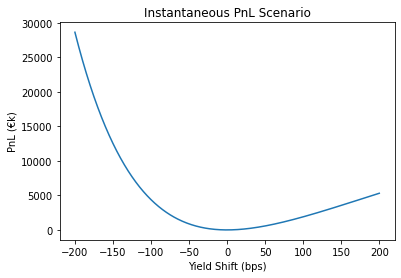

In [16]:
inst_pnl = plt.figure()
total_pnl[range(-200,201)].loc[datetime.date(2021,8,6)].T.plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Instantaneous PnL Scenario')
inst_pnl.savefig('pnl_base.png',dpi=120,bbox_inches='tight')
plt.show()

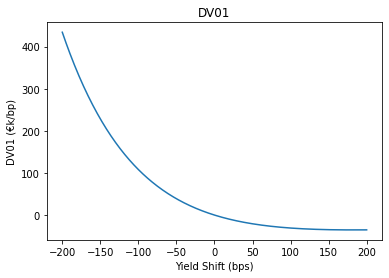

In [11]:
dv01 = plt.figure()
total_dv[range(-200,201)].loc[datetime.date(2021,8,6)].T.plot()
plt.xlabel(x_label)
plt.ylabel('DV01 (€k/bp)' )
plt.title('DV01')
dv01.savefig('dv01.png',dpi=120,bbox_inches='tight')
plt.show()

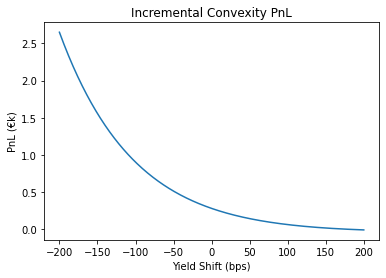

In [18]:
inc_conv = plt.figure()
(0.5*total_conv[range(-200,201)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
inc_conv.savefig('conv_base.png',dpi=120,bbox_inches='tight')
plt.show()

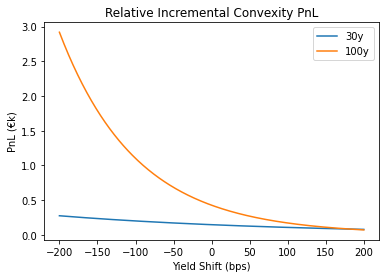

In [19]:
rel_conv = plt.figure()
((1/100)*3.38*0.5*bond_sc1[2][range(-200,201)].loc[datetime.date(2021,8,6)].T).plot(label='30y')
((1/100)*1.44*0.5*bond_sc2[2][range(-200,201)].loc[datetime.date(2021,8,6)].T).plot(label='100y')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()
plt.title('Relative Incremental Convexity PnL')
rel_conv.savefig('rel_conv.png',dpi=120,bbox_inches='tight')
plt.show()

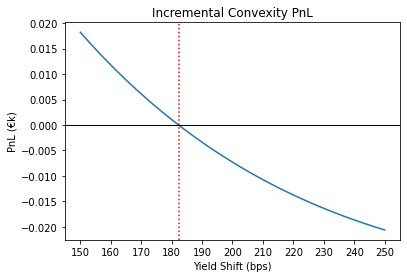

In [20]:
conv_cross = plt.figure()
(0.5*total_conv[range(150,251)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
plt.axvline(x=182.5,color='r',linestyle='dotted')
plt.axhline(y=0, color='black',linewidth=1)
conv_cross.savefig('conv_cross.png',dpi=120,bbox_inches='tight')
plt.xticks(np.arange(150,251,10))
plt.show()

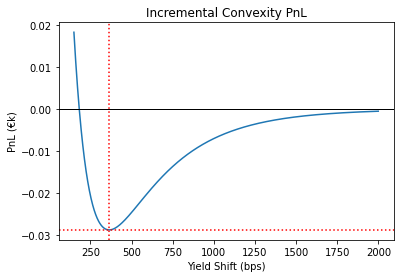

In [21]:
conv_cross_ext = plt.figure()
(0.5*total_conv[range(150,2000)].loc[datetime.date(2021,8,6)].T).plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Incremental Convexity PnL')
plt.axvline(x=364,color='r',linestyle='dotted')
plt.axhline(y=0, color='black',linewidth=1)
plt.axhline(y=-0.028837, color='r',linestyle='dotted')
conv_cross_ext.savefig('conv_cross_ext.png',dpi=120,bbox_inches='tight')
plt.show()

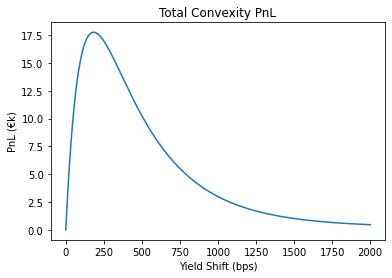

In [22]:
conv_pnl_ext = plt.figure()
convexity_pnl[range(0,2000)].loc[datetime.date(2021,8,6)].T.plot()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Total Convexity PnL')
conv_pnl_ext.savefig('conv_pnl_ext.png',dpi=120,bbox_inches='tight')
plt.show()

In [18]:
#locs = [datetime.date(2021,8,6),datetime.date(2022,8,6),datetime.date(2023,8,6),datetime.date(2026,8,6),
#        datetime.date(2031,8,6),datetime.date(2041,8,6)]
some_yrs = ['0y','1y','2y','5y','10y','20y']

In [19]:
locs = [datetime.date(2021,8,6),datetime.date(2022,8,6),datetime.date(2026,8,6),
        datetime.date(2031,8,6)]
yrs = ['0y','1y','5y','10y']
some_yrs = ['0y','1y','2y','5y','10y','20y']
all_yrs = [str(i)+'y' for i in range(0,30)]

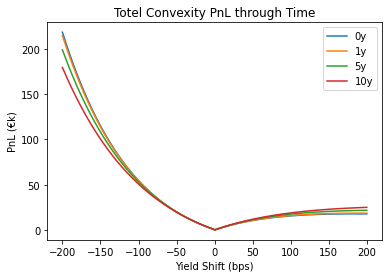

In [67]:
tot_conv_time = plt.figure()
for l in locs:
    convexity_pnl[range(-200,201)].loc[l].T.plot(label=l)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(yrs)
plt.title('Totel Convexity PnL through Time')
tot_conv_time.savefig('tot_conv_time.png',dpi=120,bbox_inches='tight')
plt.show()

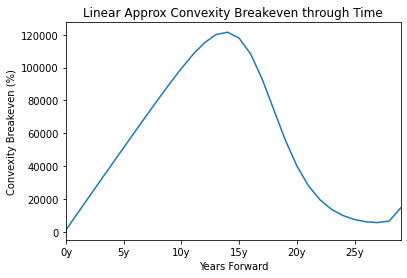

In [21]:
term_be = ((-1*convexity_pnl[10000]/(0.5*total_conv[10000]))+10000)/100
tbe = plt.figure()
term_be.index = all_yrs
term_be.plot()
plt.xlabel('Years Forward')
plt.ylabel('Convexity Breakeven (%)')
plt.title('Linear Approx Convexity Breakeven through Time')
tbe.savefig('tbe.png',dpi=120,bbox_inches='tight')
plt.margins(x=0)

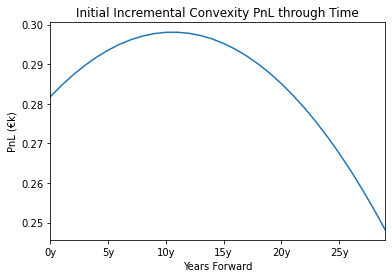

In [68]:
int_conv = plt.figure()
tct = (0.5*total_conv[0])
tct.index=all_yrs
tct.plot()
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Initial Incremental Convexity PnL through Time')
plt.margins(x=0)
int_conv.savefig('int_conv.png',dpi=120,bbox_inches='tight')
plt.show()

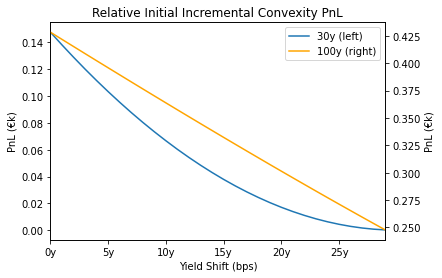

In [16]:
rel_conv_time, ax1 = plt.subplots()
ax2 = ax1.twinx()
c1 = ((1/100)*3.38*0.5*bond_sc1[2][0])
c1.index = all_yrs
c2 = ((1/100)*1.44*0.5*bond_sc2[2][0])
c2.index = all_yrs
lns1 = ax1.plot(c1.index,c1.values,label='30y (left)')
lns2= ax2.plot(c2.index,c2.values,label='100y (right)',color='orange')
ax1.set_xlabel(x_label)
ax1.set_ylabel(y_label)
ax2.set_ylabel(y_label)
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.xaxis.set_ticks(['0y','5y','10y','15y','20y','25y'])
ax1.margins(x=0)
plt.title('Relative Initial Incremental Convexity PnL')
rel_conv_time.savefig('rel_conv_time.png',dpi=120,bbox_inches='tight')
plt.show()

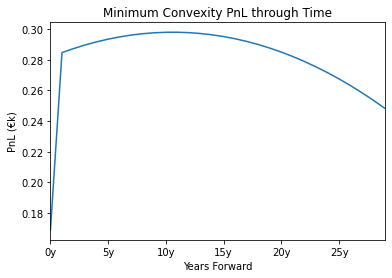

In [85]:
min_conv = plt.figure()
tct = (convexity_pnl[convexity_pnl!=0].min(axis=1))#0.5*total_conv
tct.index=all_yrs
tct.plot()
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Minimum Convexity PnL through Time')
plt.margins(x=0)
min_conv.savefig('min_conv_tot.png',dpi=120,bbox_inches='tight')
plt.show()

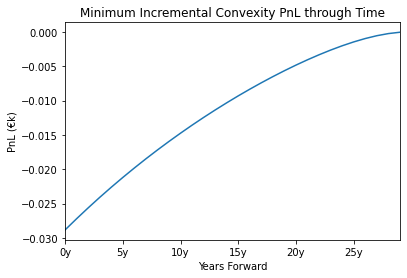

In [70]:
min_conv = plt.figure()
tct = (0.5*total_conv.min(axis=1))#0.5*total_conv
tct.index=all_yrs
tct.plot()
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Minimum Incremental Convexity PnL through Time')
plt.margins(x=0)
min_conv.savefig('min_conv_inc.png',dpi=120,bbox_inches='tight')
plt.show()

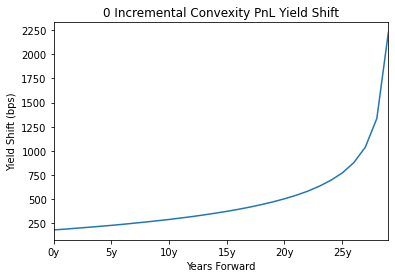

In [50]:
ind = [i[0] for i in tc_0]
vals = [i[1] for i in tc_0]
inflection_yld = plt.figure()
inflection = pd.Series(index=ind,data=vals)
inflection.index=all_yrs
inflection.plot()
plt.xlabel('Years Forward')
plt.ylabel('Yield Shift (bps)')
plt.title('0 Incremental Convexity PnL Yield Shift')
plt.margins(x=0)
inflection_yld.savefig('min_yld.png',dpi=120,bbox_inches='tight')
plt.show()

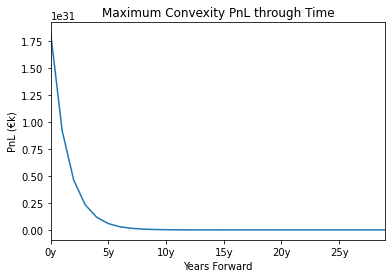

In [72]:
max_conv = plt.figure()
tct = (convexity_pnl.max(axis=1))
tct.index=all_yrs
tct.plot()
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Maximum Convexity PnL through Time')
plt.margins(x=0)
max_conv.savefig('max_conv.png',dpi=120,bbox_inches='tight')
plt.show()

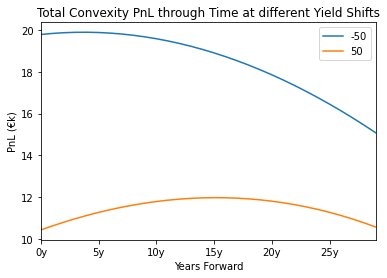

In [73]:
yld_conv = plt.figure()
ylds = [-50,50]
tct = convexity_pnl
tct.index = all_yrs
for y in ylds:
    tct[y].plot(label=y)
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Total Convexity PnL through Time at different Yield Shifts')
plt.margins(x=0)
plt.legend()
yld_conv.savefig('yld_conv.png',dpi=120,bbox_inches='tight')
plt.show()

In [74]:
comp_conv = pd.DataFrame(columns=['Flat','Roll'])
comp_conv['Flat'] = total_conv[0]
comp_conv['Roll'] = total_conv_2[0]
comp_conv

,Flat,Roll
2021-08-06,0.563650,0.563611
2022-08-06,0.569480,0.571630
2023-08-06,0.574737,0.579172
2024-08-06,0.579432,0.586222
2025-08-06,0.583539,0.592742
2026-08-06,0.587069,0.598940
2027-08-06,0.590023,0.604540
2028-08-06,0.592404,0.609512
2029-08-06,0.594198,0.613836
2030-08-06,0.595412,0.617496


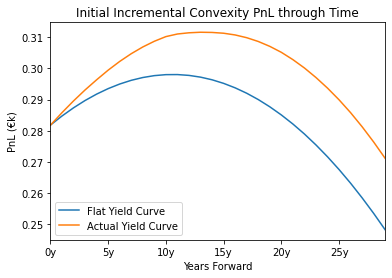

In [79]:
comp_conv = plt.figure()
tct = (0.5*total_conv[0])
tct.index=all_yrs
tct.plot(label='Flat Yield Curve')
tct2 = (0.5*total_conv_2[0])
tct2.index=all_yrs
tct2.plot(label='Actual Yield Curve')
plt.xlabel('Years Forward')
plt.ylabel(y_label)
plt.title('Initial Incremental Convexity PnL through Time')
plt.margins(x=0)
plt.legend()
comp_conv.savefig('comp_conv.png',dpi=120,bbox_inches='tight')
plt.show()

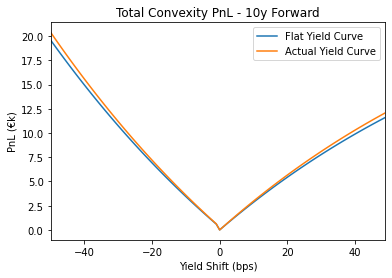

In [60]:
comp_conv_tot = plt.figure()
tct = pd.Series(convexity_pnl[range(-50,50)].loc['10y'])
#tct.index=all_yrs
tct.plot(label='Flat Yield Curve')
tct2 = pd.Series(convexity_pnl_2[range(-50,50)].loc['10y'])
#tct2.index=all_yrs
tct2.plot(label='Actual Yield Curve')
plt.xlabel('Yield Shift (bps)')
plt.ylabel(y_label)
plt.title('Total Convexity PnL - 10y Forward')
plt.margins(x=0)
plt.legend()
comp_conv_tot.savefig('comp_conv_tot.png',dpi=120,bbox_inches='tight')
plt.show()

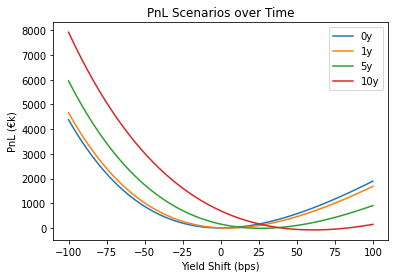

In [76]:
pnl_time = plt.figure()
for l in locs:
    total_pnl_2[range(-100,101)].loc[l].T.plot(label=l)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(yrs)
plt.title('PnL Scenarios over Time')
pnl_time.savefig('pnl_time.png',dpi=120,bbox_inches='tight')